In [3]:
import uproot
import math 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from ipywidgets import (
    IntSlider, FloatSlider, FloatText, Checkbox, Dropdown,
    HBox, VBox, Button, Output, interactive_output, Label
)
from IPython.display import display, clear_output
from tabulate import tabulate
import os
from iminuit import Minuit

%matplotlib widget

# -------------------------
# --- Gamma line database ---
# -------------------------
gamma_lines = {
    #238U Chain
    "Th-234": [{"Emin": 89, "Emax": 95, "E": 92.6, "Intensity": 4.1, "Eff": 0.0058, "HalfLife_s": 2082240.00, "Father": 238}],  #NO CHINESE DATA ON EFF, BUT OK
    "Pa-234m": [{"Emin": 992, "Emax": 1011, "E": 1001, "Intensity": 0.84, "Eff": 0.000423, "HalfLife_s": 69.57, "Father": 238}], #NO CHINESE DATA ON EFF, BUT OK
    "Ra-226": [{"Emin": 180, "Emax": 192, "E": 186.2, "Intensity": 3.57, "Eff": 0.0035,   
                "HalfLife_s": 50586832800.000, "Father": 238}],
    "Bi-214": [
        {"Emin": 602, "Emax": 616, "E": 609.3, "Intensity": 46.1, "Eff": 0.0188,
         "HalfLife_s": 1194.000, "Father": 226},
        {"Emin": 1115, "Emax": 1125, "E": 1120.3, "Intensity": 14.9, "Eff": 0.005,
         "HalfLife_s": 1194.000, "Father": 226},
        {"Emin": 1758, "Emax": 1772, "E": 1764.5, "Intensity": 15.3, "Eff": 0.0048,
         "HalfLife_s": 1194.000, "Father": 226},
    ],
    "Pb-214": [
        {"Emin": 287, "Emax": 303, "E": 295.2, "Intensity": 18.4, "Eff": 0.0132,
         "HalfLife_s": 1614.960, "Father": 226},
        {"Emin": 342, "Emax": 360, "E": 351.9, "Intensity": 35.6, "Eff": 0.0238,
         "HalfLife_s": 1614.960, "Father": 226},
    ],
    "Pb-210": [
        {"Emin": 42, "Emax": 50, "E": 46.5, "Intensity": 4.3, "Eff": 0.006,    # NO CHINESE DATA ON EFF, BUT OK
         "HalfLife_s": 703719449.800, "Father": 210},
    ],
    #232Th Chain
    "Ac-228": [{"Emin": 333, "Emax": 343, "E": 338.3, "Intensity": 11.27, "Eff": 0.0083,
                "HalfLife_s": 22140.000, "Father": 2321},
               {"Emin": 906, "Emax": 916, "E": 911.2, "Intensity": 25.8, "Eff": 0.01,
                "HalfLife_s": 22140.000, "Father": 2321},
               {"Emin": 963, "Emax": 975, "E": 969, "Intensity": 15.8, "Eff": 0.0057,
                "HalfLife_s": 22140.000, "Father": 2321}
     ],
    "Pb-212": [
        {"Emin": 232, "Emax": 243, "E": 238.6, "Intensity": 43.6, "Eff": 0.0374,
         "HalfLife_s": 38304.000, "Father": 2322},
    ],
    "Bi-212": [
        {"Emin": 722, "Emax": 732, "E": 727.3, "Intensity": 6.7, "Eff": 0.003,
         "HalfLife_s": 3632.400, "Father": 2322},
    ],
     "Tl-208": [
        {"Emin": 578, "Emax": 588, "E": 583.2, "Intensity": 85.0, "Eff": 0.0129,
         "HalfLife_s": 183.480, "Father": 2322},
         {"Emin": 2590, "Emax": 2630, "E": 2614.5, "Intensity": 99.8, "Eff": 0.0063,
         "HalfLife_s": 183.480, "Father": 2322},
    ],
    #235U Chain
    "U-235": [
        {"Emin": 138, "Emax": 149, "E": 143.8, "Intensity": 10.9, "Eff": 0.0054,
         "HalfLife_s": 39458780270400000.000, "Father": 235},
        {"Emin": 181, "Emax": 190, "E": 185.5, "Intensity": 57.2, "Eff": 0.05807, # NO CHINESE DATA ON EFF, BUT OKAY 
         "HalfLife_s": 39458780270400000.000, "Father": 235},
         {"Emin": 200, "Emax": 210, "E": 205.3, "Intensity": 5.03, "Eff": 0.025,
         "HalfLife_s": 39458780270400000.000, "Father": 235},
    ],
    # SINGLE ISOTOPES
     "K-40": [
        {"Emin": 1450, "Emax": 1470, "E": 1460.8, "Intensity": 10.7, "Eff": 0.0035,
         "HalfLife_s": 39458780270400000.000, "Father": 40}   
    ],
    "Co-60": [
        {"Emin": 1165, "Emax": 1180, "E": 1173.2, "Intensity": 99.85, "Eff": 0.0312,
         "HalfLife_s": 166344192.00, "Father": 0},
        {"Emin": 1326, "Emax": 1338, "E": 1332.5, "Intensity": 99.98, "Eff": 0.0297,
         "HalfLife_s": 166344192.00, "Father": 0}, 
    ],
    "Cs-137": [
        {"Emin": 656, "Emax": 667, "E": 661.7, "Intensity": 85.1, "Eff": 0.041,
         "HalfLife_s": 949252608.00, "Father": 0},   
     ],
}


def compute_MDA_old(Intensity, live_time, Eff, Background):
    w = 1 / (Eff * live_time)
    MDA = (2.71 + 4.65 * np.sqrt(Background) )* w
    return MDA

def compute_MDA(BKG_err, BKG_time, sample_time, Eff, sample_mass):
    w = sample_time / BKG_time
    MDA = (2.71 + 3.29 * np.sqrt(w*w +w) * BKG_err)  / (Eff * sample_mass * sample_time)  
    return MDA



# --- Load ROOT histogram ---
def read_root_histogram(filename, histoname="hmcae"):
    with uproot.open(filename) as f:
        h = f[histoname]
        edges = h.axis().edges()
        values = h.values()
    centers = 0.5 * (edges[:-1] + edges[1:])
    return centers, values, edges

# --- Read live time ---
def read_livetime(filename, treename="Parameter"):
    with uproot.open(filename) as f:
        if treename not in f:
            raise KeyError(f"Tree '{treename}' not found in {filename}")
        tree = f[treename]
        possible_keys = [k for k in tree.keys() if "live" in k.lower()]
        print(f"🔍 Available keys in '{treename}': {possible_keys}")
        try:
            live_time = tree["LiveTime"].array(library="np")[0]
        except Exception:
            if not possible_keys:
                raise KeyError(f"No live-time-like branch found in tree '{treename}'.")
            branch_name = possible_keys[0]
            live_time = tree[branch_name].array(library="np")[0]
    return float(live_time)

# --- Rebin utility ---
def rebin_histogram(x, y, factor):
    factor = int(factor)
    if factor <= 1:
        return x, y
    n = len(y) // factor
    y_rebinned = y[:n * factor].reshape(n, factor).sum(axis=1)
    x_rebinned = x[:n * factor].reshape(n, factor).mean(axis=1)
    return x_rebinned, y_rebinned

# --- Fit model definitions ---
def fit_gauss_exp(E, A, mu, sigma, B, k):
    #return A * np.exp(-0.5 * ((E - mu) / sigma) ** 2) + B * np.exp(-k * E)   # NOT NORMALIZED, AVOID!!!
    return (A / (sigma * np.sqrt(2*np.pi)))  * np.exp(-0.5 * ((E - mu) / sigma) ** 2) + B * np.exp(-k * E)    # USE THE NORMALIZED ONE

def fit_gauss_const(E, A, mu, sigma, B):
    return (A / (sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((E - mu) / sigma) ** 2) + B  # USING THE NORMALIZED ONE, A IS ALREADY THE AREA!

def fit_gauss_linear(E, A, mu, sigma, B, k):
    return (A / (sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((E - mu) / sigma) ** 2) + B + k * E

def model_wrapper(E, model_func):
    def wrapped(**params):
        return model_func(E, *params.values())
    return wrapped


# --- Negative log-likelihood for Poisson data ---
def poisson_nll(params, x, y, model_func):
    # params is a vector matching model_func signature
    model = model_func(x, *params)
    model = np.clip(model, 1e-12, None)  # Avoid zeros
    return -np.sum(y * np.log(model) - model)

# --- Chi-square function ---
def chi2(y, yfit, yerr):
    valid = yerr > 0
    return np.sum(((y[valid] - yfit[valid]) / yerr[valid]) ** 2)

def plot_root_spectrum(filename, histoname="hmcae", paramtree="Parameter"):
    # --- Read data ---
    x_centers, y_values, edges = read_root_histogram(filename, histoname)
    live_time = read_livetime(filename, paramtree)
    print(f"✅ Live time: {live_time:.3f} s ({live_time/3600:.3f} h)")

    # --- Widgets ---
    rebin_slider = IntSlider(min=1, max=64, step=1, value=1, description="Rebin")
    log_checkbox = Checkbox(value=False, description="Log scale")
    hist_style_dropdown = Dropdown(
        options=["ROOT style (bin boxes)", "Lines (step)", "Points (center)"],
        value="ROOT style (bin boxes)",
        description="Plot style:"
    )
    fit_method_dropdown = Dropdown(
        options=["Chi2 (curve_fit)", "Poisson MLE", "Minuit (Poisson)"],
        value="Minuit (Poisson)",
        description="Fit method:"
    )
    fit_button = Button(description="Fit Peaks", button_style="success")
    manual_fit_button = Button(description="Manual Fit", button_style="info")

    Emin_slider = FloatSlider(value=0, min=0, max=3000, step=3, description="Emin (keV)")
    Emax_slider = FloatSlider(value=3000, min=0, max=3000, step=3, description="Emax (keV)")
    Emin_text = FloatText(value=Emin_slider.value, description="Emin:")
    Emax_text = FloatText(value=Emax_slider.value, description="Emax:")

    # Sync sliders and text boxes
    def sync_widgets(slider, text):
        def on_slider_change(change): text.value = change['new']
        def on_text_change(change): slider.value = change['new']
        slider.observe(on_slider_change, names='value')
        text.observe(on_text_change, names='value')
    sync_widgets(Emin_slider, Emin_text)
    sync_widgets(Emax_slider, Emax_text)

    # --- Plot setup ---
    fig, ax = plt.subplots(figsize=(10, 6))
    output_area = Output()
    fit_output = Output()
    manual_fit_line = [None]  # for interactive manual fit
    manual_fit_shade = [None]
    manual_fit_output_area = Output()

    # --- Pre-fit spectrum plotting ---
    def plot_spectrum(rebin_factor, log_scale, Emin, Emax, plot_style):
        with output_area:
            clear_output(wait=True)
            ax.clear()
            x_reb, y_reb = rebin_histogram(x_centers, y_values*live_time, rebin_factor)  # MULTIPLY FOR LIVETIME!
            y_err = np.sqrt(np.maximum(y_reb, 1))

            # Plot style
            if plot_style == "ROOT style (bin boxes)":
                n_reb = len(y_reb)
                x_edges = np.linspace(edges[0], edges[-1], n_reb + 1)
                ax.step(x_edges, np.append(y_reb, y_reb[-1]), where="post", color="black", lw=1)
                ax.fill_between(x_edges[:-1], y_reb, step="post", alpha=0.2, color="gray")
            elif plot_style == "Lines (step)":
                ax.step(x_reb, y_reb, where="mid", lw=1, color="black",
                        label=f"{os.path.basename(filename)} (rebin={rebin_factor})")
            else:
                ax.plot(x_reb, y_reb, ".", ms=2, color="black",
                        label=f"{os.path.basename(filename)} (rebin={rebin_factor})")

            ax.set_xlabel("Energy (keV)")
            ax.set_ylabel("Counts/keV")
            ax.set_title(f"ROOT Spectrum: {os.path.basename(filename)}")
            ax.grid(True)
            if log_scale:
                ax.set_yscale("log")

            # ROI info
            ax.axvspan(Emin, Emax, color='orange', alpha=0.3)
            mask = (x_reb >= Emin) & (x_reb <= Emax)
            rate_in_region = np.sum(y_reb[mask]) * 1e3 / live_time
            counts_in_region = np.sum(y_reb[mask])  
            print(f"ROI: {Emin:.1f} – {Emax:.1f} keV")
            print(f"Total counts in region: {counts_in_region:.0f}")
            print(f"Total rate in region: {rate_in_region:.3f} mHz\n")

            # Gamma line pre-fit annotations
            print("📊 Gamma Line Integration (pre-fit):")
            colors = plt.cm.tab10.colors
            color_index = 0

            # OLD FOR SINGLE COLORS
            
            for isotope, lines in gamma_lines.items():
                print(f"\n→ {isotope}")
                for line in lines:
                    Emin_fit, Emax_fit = line["Emin"], line["Emax"]
                    print(f"  {line['E']:.1f} keV | Range: {Emin_fit}-{Emax_fit} keV | Intensity: {line['Intensity']}%")

                    # 238U Chain
                    if line["Father"] == 238:
                        ax.axvspan(Emin_fit, Emax_fit, color='deepskyblue', alpha=0.2)
                        ax.axvline(line["E"], color='deepskyblue', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='deepskyblue')
                    if line["Father"] == 226:
                        ax.axvspan(Emin_fit, Emax_fit, color='dodgerblue', alpha=0.2)
                        ax.axvline(line["E"], color='dodgerblue', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='dodgerblue')
                    if line["Father"] == 210:
                        ax.axvspan(Emin_fit, Emax_fit, color='lightsteelblue', alpha=0.2)
                        ax.axvline(line["E"], color='lightsteelblue', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='lightsteelblue')
                    # 232Th Chain

                    if line["Father"] == 2321:
                        ax.axvspan(Emin_fit, Emax_fit, color='darkorange', alpha=0.2)
                        ax.axvline(line["E"], color='darkorange', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='darkorange')   
                    if line["Father"] == 2322:
                        ax.axvspan(Emin_fit, Emax_fit, color='hotpink', alpha=0.2)
                        ax.axvline(line["E"], color='hotpink', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='hotpink')

                    if line["Father"] == 235:
                        ax.axvspan(Emin_fit, Emax_fit, color='darkred', alpha=0.2)
                        ax.axvline(line["E"], color='darkred', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='darkred')

                    if line["Father"] == 40:
                        ax.axvspan(Emin_fit, Emax_fit, color='olive', alpha=0.2)
                        ax.axvline(line["E"], color='olive', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='olive')

                    if line["Father"] == 0:
                        ax.axvspan(Emin_fit, Emax_fit, color='g', alpha=0.2)
                        ax.axvline(line["E"], color='g', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='g')

                    
                    
                    '''
                    # OLD FOR SINGLE COLORS
                    
                    ax.axvspan(Emin_fit, Emax_fit, color=colors[color_index % len(colors), alpha=0.2)
                    ax.axvline(line["E"], color=colors[color_index % len(colors)], linestyle="--", alpha=0.6)
                    ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color=colors[color_index % len(colors)])
                    color_index += 1
                    '''
            ax.legend()
            fig.canvas.draw()
        return x_reb, y_reb, y_err

    x_reb, y_reb, y_err = plot_spectrum(rebin_slider.value, log_checkbox.value,
                                        Emin_slider.value, Emax_slider.value,
                                        hist_style_dropdown.value)

    # --- Fit peaks callback ---
    def fit_peaks_callback(_):
        with fit_output:
            clear_output(wait=True)
            print(f"\n📈 Fit Results Summary ({fit_method_dropdown.value}):\n")
            colors = plt.cm.tab10.colors
            color_index = 0

            for isotope, lines in gamma_lines.items():
                table_data = []
                for line in lines:
                    Emin_fit, Emax_fit = line["Emin"], line["Emax"]
                    mask_line = (x_reb >= Emin_fit) & (x_reb <= Emax_fit)
                    x_fit, y_fit, yerr_fit = x_reb[mask_line], y_reb[mask_line], y_err[mask_line]
                    if len(x_fit) < 5:
                        table_data.append([f"{line['E']:.1f}"]*7)
                        continue
                    try:
                        p0 = [max(y_fit), line["E"], 3, max(y_fit)/2, 1e-3]
                        bounds = ([0, -np.inf, 0, 0, 0], [np.inf]*5)

                        if fit_method_dropdown.value == "Chi2 (curve_fit)":
                            popt, pcov = curve_fit(fit_gauss_exp, x_fit, y_fit, p0=p0,
                                                   sigma=yerr_fit, absolute_sigma=True, bounds=bounds)
                            perr = np.sqrt(np.diag(pcov))
                            yfit = fit_gauss_exp(x_fit, *popt)
                        else:
                            result = minimize(poisson_nll, p0, args=(x_fit, y_fit, fit_gauss_exp),
                                              bounds=bounds, method='L-BFGS-B')
                            popt = result.x
                            perr = np.full_like(popt, np.nan)
                            yfit = fit_gauss_exp(x_fit, *popt)

                        ndf = len(y_fit) - len(popt)
                        red_chi2 = chi2(y_fit, yfit, yerr_fit)/ndf if ndf>0 else np.nan

                        # Area and counts
                        A, mu, sigma, B, k = popt
                        #area_hz = A * sigma * np.sqrt(2*np.pi)
                        #area_counts = area_hz * live_time

                        table_data.append([
                            f"{line['E']:.1f}",
                            f"{mu:.2f} ± {perr[1]:.2f}",
                            f"{sigma:.2f} ± {perr[2]:.2f}",
                            f"{area_counts:.1f} ± {np.nan if np.isnan(perr[0]) else area_hz*perr[0]*live_time:.1f}",
                            f"{B:.2e} ± {perr[3]:.2e}",
                            f"{k:.3e} ± {perr[4]:.3e}",
                            f"{red_chi2:.4f}"
                        ])
                        x_dense = np.linspace(Emin_fit, Emax_fit, 200)
                        ax.plot(x_dense, fit_gauss_exp(x_dense, *popt),
                                color=colors[color_index % len(colors)], lw=1.5)

                    except Exception:
                        table_data.append([f"{line['E']:.1f}"]*7)

                    
                    '''
                    # OLD FOR SINGLE COLORS
                    # Color-coded areas
                    ax.axvspan(Emin_fit, Emax_fit, color=colors[color_index % len(colors)], alpha=0.2)
                    ax.axvline(line["E"], color=colors[color_index % len(colors)], linestyle="--", alpha=0.6)
                    ax.text(line["E"], np.max(y_reb)*0.9, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=8,
                            color=colors[color_index % len(colors)])
                    color_index += 1
                    '''
                    
                    if line["Father"] == 238:
                        ax.axvspan(Emin_fit, Emax_fit, color='deepskyblue', alpha=0.2)
                        ax.axvline(line["E"], color='deepskyblue', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='deepskyblue')
                    if line["Father"] == 226:
                        ax.axvspan(Emin_fit, Emax_fit, color='dodgerblue', alpha=0.2)
                        ax.axvline(line["E"], color='dodgerblue', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='dodgerblue')
                    if line["Father"] == 210:
                        ax.axvspan(Emin_fit, Emax_fit, color='lightsteelblue', alpha=0.2)
                        ax.axvline(line["E"], color='lightsteelblue', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='lightsteelblue')
                    # 232Th Chain

                    if line["Father"] == 2321:
                        ax.axvspan(Emin_fit, Emax_fit, color='darkorange', alpha=0.2)
                        ax.axvline(line["E"], color='darkorange', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='darkorange')   
                    if line["Father"] == 2322:
                        ax.axvspan(Emin_fit, Emax_fit, color='hotpink', alpha=0.2)
                        ax.axvline(line["E"], color='hotpink', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='hotpink')

                    if line["Father"] == 235:
                        ax.axvspan(Emin_fit, Emax_fit, color='darkred', alpha=0.2)
                        ax.axvline(line["E"], color='darkred', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='darkred')

                    if line["Father"] == 40:
                        ax.axvspan(Emin_fit, Emax_fit, color='olive', alpha=0.2)
                        ax.axvline(line["E"], color='olive', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='olive')

                    if line["Father"] == 0:
                        ax.axvspan(Emin_fit, Emax_fit, color='g', alpha=0.2)
                        ax.axvline(line["E"], color='g', linestyle="--", alpha=0.6)
                        ax.text(line["E"], np.max(y_reb)*0.65, f"{isotope}",
                            rotation=90, va='bottom', ha='center', fontsize=10,
                            color='g')
                
                if table_data:
                    headers = ["E (keV)", "μ (keV)", "σ (keV)", "Area (counts)", "B", "k", "χ²/ndf"]
                    print(f"\n→ {isotope}")
                    print(tabulate(table_data, headers=headers, tablefmt="grid"))

            fig.canvas.draw()

    fit_button.on_click(fit_peaks_callback)

    # --- Manual Fit window (fully functional with Minuit, Chi2, Poisson) ---
    def manual_fit_window(_):
        with fit_output:
            clear_output(wait=True)
            print("🎛️ Manual Fit — set range, initial params, bounds, model and method, then Run Fit\n")

            Emin_manual = FloatText(value=Emin_slider.value, description="Emin (keV)")
            Emax_manual = FloatText(value=Emax_slider.value, description="Emax (keV)")

            model_choice = Dropdown(
                options=["Gaussian + exp background", "Gaussian + const background", "Gaussian + linear + flat background"],
                value="Gaussian + linear + flat background",
                description="Model:"
            )

            method_choice = Dropdown(
                options=["Chi2 (curve_fit)", "Poisson MLE", "Minuit (Poisson)"],
                value=fit_method_dropdown.value,
                description="Method:"
            )

            # --- Initial parameters ---
            A_init = FloatText(value=float(np.max(y_reb)), description="A init")
            mu_init = FloatText(value=float(np.mean(x_reb)), description="μ init")
            sigma_init = FloatText(value=3.0, description="σ init")
            B_init = FloatText(value=float(np.min(y_reb)), description="B init")
            k_init = FloatText(value=-1e-3, description="k init (for exp)")

            # --- Bounds ---
            A_min = FloatText(value=0.0, description="A min")
            A_max = FloatText(value=float(np.max(y_reb))*10.0, description="A max")
            mu_min = FloatText(value=Emin_manual.value, description="μ min")
            mu_max = FloatText(value=Emax_manual.value, description="μ max")
            sigma_min = FloatText(value=0.1, description="σ min")
            sigma_max = FloatText(value=10.0, description="σ max")
            B_min = FloatText(value=0.0, description="B min")
            B_max = FloatText(value=float(np.max(y_reb))*1.0, description="B max")
            k_min = FloatText(value=-10.0, description="k min")
            k_max = FloatText(value=1.0, description="k max")

            run_fit_button = Button(description="Run Fit", button_style="success")
            mf_text_output = manual_fit_output_area
            with mf_text_output: clear_output(wait=True)

            # --- Run manual fit ---
            def run_manual_fit(_):
                with mf_text_output:
                    clear_output(wait=True)
                    if manual_fit_line[0] is not None:
                        try: manual_fit_line[0].remove()
                        except: pass
                        manual_fit_line[0] = None
                    if manual_fit_shade[0] is not None:
                        try: manual_fit_shade[0].remove()
                        except: pass
                        manual_fit_shade[0] = None

                    Emin_val, Emax_val = Emin_manual.value, Emax_manual.value

                    # --- Choose model ---
                    if model_choice.value == "Gaussian + exp background":
                        model_func = fit_gauss_exp
                        param_names = ["A","mu","sigma","B","k"]
                        p0 = [A_init.value, mu_init.value, sigma_init.value, B_init.value, k_init.value]
                        lower = [A_min.value, mu_min.value, sigma_min.value, B_min.value, k_min.value]
                        upper = [A_max.value, mu_max.value, sigma_max.value, B_max.value, k_max.value]
                    elif model_choice.value == "Gaussian + const background":
                        model_func = fit_gauss_const
                        param_names = ["A","mu","sigma","B"]
                        p0 = [A_init.value, mu_init.value, sigma_init.value, B_init.value]
                        lower = [A_min.value, mu_min.value, sigma_min.value, B_min.value]
                        upper = [A_max.value, mu_max.value, sigma_max.value, B_max.value]
                    else:
                        model_func = fit_gauss_linear
                        param_names = ["A","mu","sigma","B","k"]
                        p0 = [A_init.value, mu_init.value, sigma_init.value, B_init.value, k_init.value]
                        lower = [A_min.value, mu_min.value, sigma_min.value, B_min.value, k_min.value]
                        upper = [A_max.value, mu_max.value, sigma_max.value, B_max.value, k_max.value]

                    # --- Select data ---
                    mask_line = (x_reb >= Emin_val) & (x_reb <= Emax_val)
                    x_fit, y_fit = x_reb[mask_line], y_reb[mask_line]
                    yerr_fit = np.sqrt(np.maximum(y_fit, 1.0))
                    if len(x_fit) < 5:
                        print("⚠️ Too few points in selected range.")
                        return

                   

                        
                    try:
                        if method_choice.value == "Chi2 (curve_fit)":
                            popt, pcov = curve_fit(model_func, x_fit, y_fit, p0=p0, bounds=(lower, upper),
                                                   sigma=yerr_fit, absolute_sigma=True)
                            perr = np.sqrt(np.diag(pcov))
                        elif method_choice.value == "Poisson MLE":
                            result = minimize(poisson_nll, p0, args=(x_fit, y_fit, model_func),
                                              bounds=list(zip(lower, upper)))
                            popt = result.x
                            perr = np.full_like(popt, np.nan)
                        else:  # Minuit
                            
                            if model_choice.value == "Gaussian + exp background":
                                def minuit_nll(A, mu, sigma, B, k):
                                    model = fit_gauss_exp(x_fit, A, mu, sigma, B, k)
                                    return np.sum(model - y_fit * np.log(model + 1e-12))
                                m = Minuit(minuit_nll, A=A_init.value, mu=mu_init.value, sigma=sigma_init.value,
                                    B=B_init.value, k=k_init.value)
                                m.limits["A"] = (A_min.value, A_max.value)
                                m.limits["mu"] = (mu_min.value, mu_max.value)
                                m.limits["sigma"] = (sigma_min.value, sigma_max.value)
                                m.limits["B"] = (B_min.value, B_max.value)
                                m.limits["k"] = (k_min.value, k_max.value)
                            elif model_choice.value == "Gaussian + const background":
                                def minuit_nll(A, mu, sigma, B):
                                    model = fit_gauss_const(x_fit, A, mu, sigma, B)
                                    return np.sum(model - y_fit * np.log(model + 1e-12))
                                m = Minuit(minuit_nll, A=A_init.value, mu=mu_init.value, sigma=sigma_init.value,
                                           B=B_init.value)
                                m.limits["A"] = (A_min.value, A_max.value)
                                m.limits["mu"] = (mu_min.value, mu_max.value)
                                m.limits["sigma"] = (sigma_min.value, sigma_max.value)
                                m.limits["B"] = (B_min.value, B_max.value)
                            else:  # Gaussian + linear
                                def minuit_nll(A, mu, sigma, B, k):
                                    model = fit_gauss_linear(x_fit, A, mu, sigma, B, k)
                                    #return np.sum(model - y_fit * np.log(model + 1e-12))
                                    model = np.clip(model, 1e-12, None)
                                    return np.sum(model - y_fit * np.log(model))


                                m = Minuit(minuit_nll, A=A_init.value, mu=mu_init.value, sigma=sigma_init.value,
                                           B=B_init.value, k=k_init.value)
                                m.limits["A"] = (A_min.value, A_max.value)
                                m.limits["mu"] = (mu_min.value, mu_max.value)
                                m.limits["sigma"] = (sigma_min.value, sigma_max.value)
                                m.limits["B"] = (B_min.value, B_max.value)
                                m.limits["k"] = (k_min.value, k_max.value)

                            
                        

                            m.errordef = Minuit.LIKELIHOOD
                            m.migrad()
                            m.hesse()

                            
                            popt = np.array([m.values[n] for n in param_names])
                            perr = np.array([m.errors[n] for n in param_names])

                        # --- Post-fit calculations ---
                        yfit = model_func(x_fit, *popt)
                        ndf = len(y_fit) - len(popt)
                        red_chi2 = chi2(y_fit, yfit, yerr_fit)/ndf if ndf>0 else np.nan

                        A_val, mu_val, sigma_val = popt[0], popt[1], popt[2]
                        A_err, mu_err, sigma_err = perr[0], perr[1], perr[2]

                        ''' OLD, WITH NON NORMALIZED GAUSSIAN!!!
                        area = A_val * sigma_val * np.sqrt(2*np.pi)
                        area_err = np.sqrt(2*np.pi * ( (sigma_val * A_err)**2 + (A_val * sigma_err)**2 ))
                        '''
                        
                        area_hz = A_val / live_time
                        

                        # TO COMPUTE MDA with sideband method 
                        
                        region_half_width = 3*sigma_val
                        peak_region = (x_reb >= mu_val-region_half_width) & (x_reb <= mu_val+region_half_width)

                        integral_counts = np.sum(y_reb[peak_region])

                        BKG_left = (x_reb >= mu_val-region_half_width-3*sigma_val) & (x_reb < mu_val - region_half_width)
                        BKG_right = (x_reb > mu_val+region_half_width) & (x_reb <= mu_val + region_half_width + 3*sigma_val)
                        
                        BKG_counts_left = np.sum(y_reb[BKG_left]) 
                        BKG_counts_right = np.sum(y_reb[BKG_right])

                        
                        net_counts = integral_counts - ((BKG_counts_left + BKG_counts_right)/2)
                        err_net_counts = np.sqrt(np.sqrt(integral_counts)**2+ (0.5 * np.sqrt(BKG_counts_left))**2  + (0.5 * np.sqrt(BKG_counts_right))**2)


                        
                        
                        # --- Activity / MDA calculation ---
                        Activity, MDA, Activity_mass, MDA_sampleT = np.nan, np.nan, np.nan, np.nan
                        MDA_fitting, MDA_sideband = np.nan, np.nan
                        for isotope, lines in gamma_lines.items():
                            for line in lines:
                                if abs(mu_val - line["E"]) <= 2:
                                    '''OLD, NON NORMALIZED GAUSSIAN! DON'T USE
                                    Activity = area / (1e-2 * line["Intensity"]*live_time)
                                    Activity_err = area_err / (1e-2 * line["Intensity"]*live_time)
                                    
                                    MDA_fitting = compute_MDA(area_err, live_time, 441000, line["Eff"], 0.1925)
                                    '''
                                    Activity = A_val / (1e-2 * line["Intensity"]*live_time)
                                    Activity_err = A_err / (1e-2 * line["Intensity"]*live_time)

                                    MDA_fitting = compute_MDA(A_err, live_time, 441000, line["Eff"], 0.1925)
                                    
                                    #MDA_test = compute_MDA(14.3, live_time, 441000, line["Eff"], 0.1925) # CHINESE DATA ON 228Ac 911 keV peak
                                    
                                    MDA_sideband = compute_MDA(np.sqrt(net_counts), live_time, 441000, line["Eff"], 0.1925)
                                    
                                    #MDA = compute_MDA_old(line["Intensity"], live_time, line["Eff"], integral_counts)
                                    #Activity_mass = Activity / 0.1925
                                    #MDA_sampleT = compute_MDA(line["Intensity"], 441000, line["Eff"], integral_counts*(441000/live_time))
                                    print(f"\n→ {isotope}\n")

                        # --- Print results ---
                        headers = ["param", "value", "error"]
                        rows = []
                        for i, val in enumerate(popt):
                            err = perr[i] if i < len(perr) else np.nan
                            rows.append([f"p{i}", f"{val:.6g}", f"{err:.6g}" if not np.isnan(err) else "—"])
                        print(tabulate(rows, headers=headers, tablefmt="grid"))
                        print(f"\nμ = {mu_val:.3f} +/- {mu_err:.3f} keV")
                        print(f"σ = {sigma_val:.3f} +/- {sigma_err:.3f} keV")
                        print(f"FWHM = {2.35*sigma_val:.3f} +/- {2.35*sigma_err:.3f} keV")
                        print(f"Reduced χ² = {red_chi2:.4f}")
                        print(f"Integrated peak area in Hz = {area_hz:.6g} Hz")
                        print(f"Total peak counts = {A_val:.6g} +/- {A_err:.6g} counts (live time = {live_time:.3f} s)")
                        print(f"Activity = {1e3*Activity:.3f} +/_ {1e3*Activity_err:.3f} mBq")

                        

                       # print(f"MDA tset from slides (only peak area) = {1e3*MDA_test:.3f} mBq/Kg for approx 200 g Li2CO3")
                        
                        print(f"Integral counts in 3σ region = {integral_counts:.6g} +/- {np.sqrt(integral_counts):.6g} counts") 
                        print(f"Net counts in 3σ region = {net_counts:.6g} +/- {err_net_counts:.6g} counts")
                        
                        print(f"MDA sideband  = {1e3*MDA_sideband:.3f} mBq/Kg for approx 200 g Li2CO3")
                        print(f"MDA fitting (only peak area) = {1e3*MDA_fitting:.3f} mBq/Kg for approx 200 g Li2CO3")
                        
                        #print(f"Weighted MDA = {1e3*np.sqrt(MDA_sideband*MDA_sideband + MDA_fitting*MDA_fitting)/2:.3f} mBq/Kg for approx 200 g Li2CO3")
                        

                        
                        # --- Plot manual fit ---
                        x_dense = np.linspace(Emin_val, Emax_val, 400)
                        (manual_fit_line[0],) = ax.plot(x_dense, model_func(x_dense, *popt),
                                                       'r-', lw=2, label="Manual fit")
                        x_shade = np.linspace(mu_val - 4*sigma_val, mu_val + 4*sigma_val, 200)
                        if model_choice.value == "Gaussian + exp background":
                            B, k = popt[3], popt[4]
                            background = B * np.exp(-k * x_shade)
                        elif model_choice.value == "Gaussian + const background":
                            B = popt[3]; background = np.full_like(x_shade, B)
                        else:
                            B, k = popt[3], popt[4]; background = B + k*x_shade
                            
                        gauss = (popt[0] / (sigma_val * np.sqrt(2*np.pi)))*np.exp(-0.5*((x_shade - mu_val)/sigma_val)**2)
                        manual_fit_shade[0] = ax.fill_between(x_shade, background, background+gauss,
                                                             color='red', alpha=0.3, label="Gaussian area")
                        ax.legend(); fig.canvas.draw()
                    except Exception as e:
                        print("❌ Fit failed:", e)

            run_fit_button.on_click(run_manual_fit)

            display(VBox([
                HBox([model_choice, method_choice, run_fit_button]),
                HBox([A_init, mu_init, sigma_init, B_init, k_init]),
                HBox([A_min, A_max, mu_min, mu_max]),
                HBox([sigma_min, sigma_max, B_min, B_max, k_min, k_max]),
                HBox([Emin_manual, Emax_manual]),
                mf_text_output
            ]))

    manual_fit_button.on_click(manual_fit_window)

    # --- Update plot callback ---
    def update_plot(rebin_factor, log_scale, Emin, Emax, plot_style):
        nonlocal x_reb, y_reb, y_err
        if manual_fit_line[0] is not None:
            try: manual_fit_line[0].remove()
            except: pass
            manual_fit_line[0] = None
        if manual_fit_shade[0] is not None:
            try: manual_fit_shade[0].remove()
            except: pass
            manual_fit_shade[0] = None
        x_reb, y_reb, y_err = plot_spectrum(rebin_factor, log_scale, Emin, Emax, plot_style)

    controls = VBox([
        HBox([rebin_slider, log_checkbox, hist_style_dropdown, fit_method_dropdown,
              fit_button, manual_fit_button]),
        HBox([Emin_slider, Emax_slider]),
        HBox([Emin_text, Emax_text]),
        output_area,
        fit_output
    ])
    out = interactive_output(update_plot, {
        'rebin_factor': rebin_slider,
        'log_scale': log_checkbox,
        'Emin': Emin_slider,
        'Emax': Emax_slider,
        'plot_style': hist_style_dropdown
    })

    display(controls, out)


🔍 Available keys in 'Parameter': ['livetime']
✅ Live time: 1618200.000 s (449.500 h)


Output()

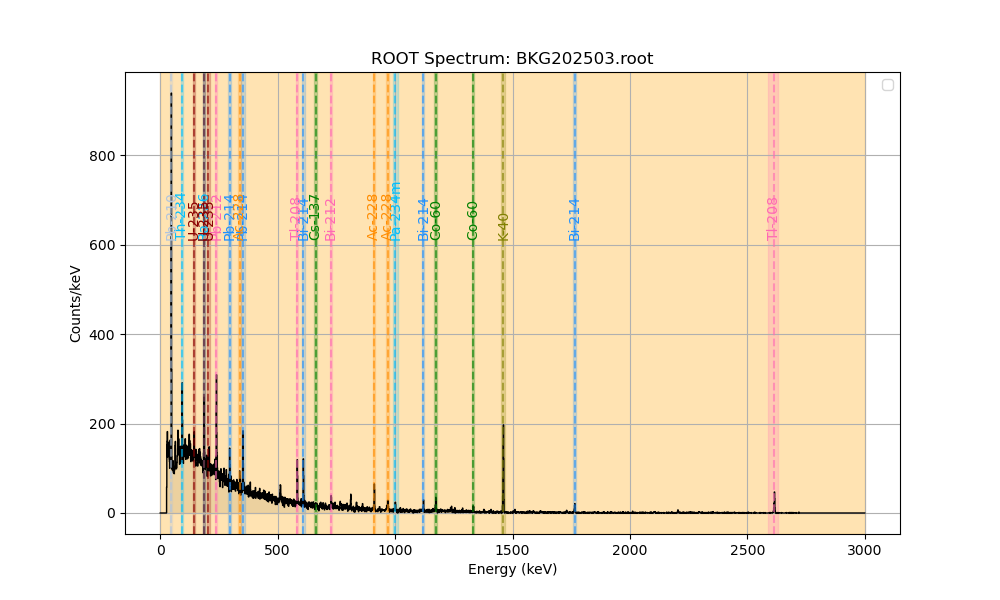

In [5]:
plot_root_spectrum("/home/brada/Desktop/Radiopurity Spurious Data/Chinese Data/BKG202503.root", "hmcae")